### This notebook includes the experiments for cross validation.

- Standing agent is P1, we are learning P2 (P2 is human player).

- Some frames will be removed, there are frames that;
    - Both players standing.
    - Consecutive ones(If frame's action is same with previous frame, it will be removed).
    - If we are(P2) in RECOV frame(Since we don't make RECOV frames ourselves).

### Importing libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard
import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import json

# For using core package that located in the two upper folder.
import os,sys
sys.path.append('../../')

from core.json_importer import parse_json_file, parse_all_files
from core.filters import remove_both_standing_frames, remove_same_consecutive_actions, remove_recov_frames
from core.actions import one_hot_encode, decode
from core.preproccessing import Normalizer
from core.helpers import write_file

Using TensorFlow backend.


In [2]:
# Create out file folder if not exists
OUT_FOLDER = 'conf_matrix_out'
if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)

In [3]:
# Open files
training_data = parse_all_files("data/train")
testing_data = parse_all_files("data/test")

### Pre process data

- In the pre process phase, we remove P2's datas from training set in order to crate labels. Labels are just actions of P2.

- We make actions one-hot encoding. 

- One-hot encoding for inputs and labels are not same. For example, Dash action in the input may have encoding [0,1] while Dash action in the label have encoding [0, 0, 1, 0].

- Integer values normalized. (P1-HP, P2-HP, P1-X, P1-Y, P2-X, P2-Y)

- After pre-process we just have <font color='red'>[P1-Action, P1-HP, P2-HP, P1-X, P1-Y, P2-X, P2-Y] -> P2-Action</font>

#### Remove unneeded frames

In [4]:
# Apply filters for training data
tr_deleted = training_data.filter(remove_both_standing_frames)
tr_deleted += training_data.filter(remove_recov_frames)
tr_deleted += training_data.filter(remove_same_consecutive_actions)

# Apply filters for training data
te_deleted = testing_data.filter(remove_both_standing_frames)
te_deleted += testing_data.filter(remove_recov_frames)
te_deleted += testing_data.filter(remove_same_consecutive_actions)

print('There are {} train data.({} deleted.)'.format(len(training_data), tr_deleted))
print('There are {} test data.({} deleted.)'.format(len(testing_data), te_deleted))

There are 11428 train data.(485372 deleted.)
There are 1221 test data.(52779 deleted.)


#### Encoding and normalization

In [5]:
def normalize_and_save(data, file_name):
    p1_hp_normalizer = Normalizer()
    p1_normalized_hp = p1_hp_normalizer.normalize(data)
    p1_hp_normalizer.save(OUT_FOLDER + '/' + file_name)
    return p1_normalized_hp

def process_data(game_data_obj):
    ## Pre process data
    processed_data = []

    # Create one hot encoding for actions (For input and labels)
    p1_one_hot_encoded_actions = one_hot_encode(game_data_obj.get_column("P1-action"))
    labels = one_hot_encode(game_data_obj.get_column("P2-action"))

    # Normalize uncategorized features
    p1_normalized_hp = normalize_and_save(game_data_obj.get_column("P1-hp"), "p1_hp_norm.save")
    p2_normalized_hp = normalize_and_save(game_data_obj.get_column("P2-hp"), "p2_hp_norm.save")
    normalized_xp1_distance = normalize_and_save([frame["P1-x"] for frame in game_data_obj], "xp1_norm.save")
    normalized_xp2_distance = normalize_and_save([frame["P2-x"] for frame in game_data_obj], "xp2_norm.save")
    normalized_yp1_distance = normalize_and_save([frame["P1-y"] for frame in game_data_obj], "yp1_norm.save")
    normalized_yp2_distance = normalize_and_save([frame["P2-y"] for frame in game_data_obj], "yp2_norm.save")

    for index in range(len(game_data_obj)):    
        processed_row = []
        processed_row.extend(p1_one_hot_encoded_actions[index])
        processed_row.extend(p1_normalized_hp[index]) 
        processed_row.extend(p2_normalized_hp[index])
        processed_row.extend(normalized_xp1_distance[index])
        processed_row.extend(normalized_xp2_distance[index])
        processed_row.extend(normalized_yp1_distance[index])
        processed_row.extend(normalized_yp2_distance[index])
        processed_data.append(processed_row)
    processed_data = np.array(processed_data)
    labels = np.array(labels)
    
    return processed_data, labels
    
tr_data, tr_labels = process_data(training_data)
te_data, te_labels = process_data(testing_data)

### Example data

In [6]:
EXAMPLE_ROW = 10

print("There are %d frames in dataset." % len(tr_data))
print("After pre processing the shape of our dataset is %s" % str(tr_data.shape))
print("\nOne example in index %d." % EXAMPLE_ROW)

row = tr_data[EXAMPLE_ROW]
print("\tProcessed Frame:" )
print("\t\tP1 Action(one-hot) Shape:\t[1, %d]" % 54)
print("\t\tP1 Hp(norm.):\t\t\t%s" % row[55])
print("\t\tP2 Hp(norm.):\t\t\t%s" % row[56])
print("\t\tX Dist(norm.):\t\t\t%s" % row[57])
print("\t\tY Dist(norm.):\t\t\t%s" % row[58])
print("\t\tLabel Shape:\t\t\t[1, %d]" % len(tr_labels[EXAMPLE_ROW]))

There are 11428 frames in dataset.
After pre processing the shape of our dataset is (11428, 61)

One example in index 10.
	Processed Frame:
		P1 Action(one-hot) Shape:	[1, 54]
		P1 Hp(norm.):			0.01594896331738437
		P2 Hp(norm.):			0.010683760683760684
		X Dist(norm.):			0.0425
		Y Dist(norm.):			0.08625000000000001
		Label Shape:			[1, 55]


### Neural Network Design

Our neural network has two hidden layers in this test. They has 12 and 8 neurons respectively.

In [7]:
# Constants
INPUT_LAYER_SIZE = tr_data.shape[1]
OUTPUT_LAYER_SIZE = tr_labels.shape[1]

In [8]:
def create_model(neuron_count):
    model = Sequential()
    model.add(Dense(neuron_count, input_dim=INPUT_LAYER_SIZE, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_LAYER_SIZE, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
EPOCH = 50
BATCH = 10

In [10]:
model = create_model(50)

history = model.fit(tr_data, tr_labels, epochs=EPOCH, validation_split=0.2,
                shuffle=True, batch_size=BATCH)

scores = model.evaluate(te_data, te_labels)
print("\t\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 9142 samples, validate on 2286 samples
Epoch 1/50
9142/9142 [==============================] - 3s 377us/step - loss: 0.1152 - acc: 0.9707 - val_loss: 0.0644 - val_acc: 0.9818
Epoch 2/50
9142/9142 [==============================] - 3s 350us/step - loss: 0.0649 - acc: 0.9819 - val_loss: 0.0606 - val_acc: 0.9819
Epoch 3/50
9142/9142 [==============================] - 3s 368us/step - loss: 0.0617 - acc: 0.9821 - val_loss: 0.0584 - val_acc: 0.9823
Epoch 4/50
9142/9142 [==============================] - 3s 351us/step - loss: 0.0599 - acc: 0.9823 - val_loss: 0.0569 - val_acc: 0.9825
Epoch 5/50
9142/9142 [==============================] - 3s 332us/step - loss: 0.0587 - acc: 0.9824 - val_loss: 0.0560 - val_acc: 0.9825
Epoch 6/50
9142/9142 [==============================] - 3s 330us/step - loss: 0.0579 - acc: 0.9825 - val_loss: 0.0554 - val_acc: 0.9827
Epoch 7/50
9142/9142 [==============================] - 3s 315us/step - loss: 0.0572 - acc: 0.9825 - val_loss: 0.0551 - val_acc: 0.9827


In [148]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, predicted_labes):
    def get_action_list():
        tmp = {}
        labels = te_labels.argmax(axis=1)
        for l in labels:
            tmp[DISTINCT_ACTIONS[l]] = l

        def find_min(dic):
            _min = len(DISTINCT_ACTIONS) + 1
            key = None
            for item, index in dic.items():
                if index < _min:
                    _min = index
                    key = item
            del tmp[key]
            return _min

        actions = []
        while(tmp.keys()):
            actions.append(DISTINCT_ACTIONS[find_min(tmp)])

        return actions
    
    def plot(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = '.1f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    cnf_matrix = confusion_matrix(te_labels.argmax(axis=1), y_pred.argmax(axis=1))
    
    plt.figure(figsize=(14, 14))
    plot(cnf_matrix, classes=get_action_list())
    plt.show()

In [147]:
y_pred = model.predict(te_data)

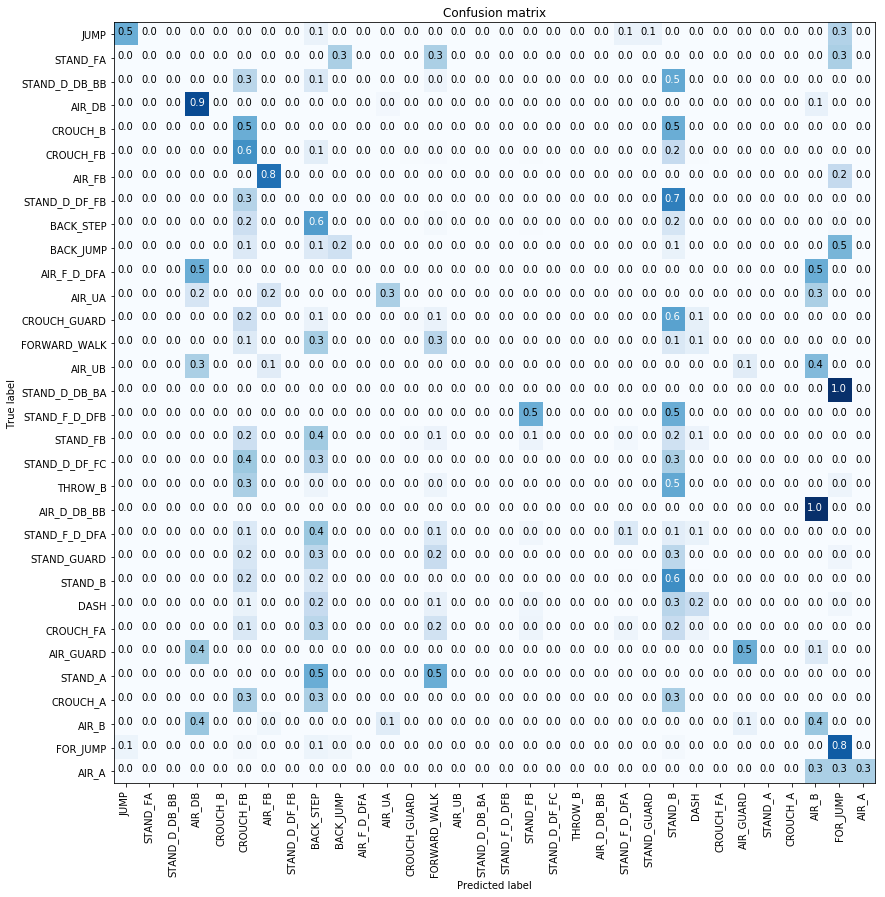

In [149]:
plot_confusion_matrix(te_labels, y_pred)